# Home Credit Default Risk - Exploratory Data Analysis (EDA)

**Project:** AI-Powered Intelligent Risk Management System  
**Dataset:** [Kaggle - Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk)  
**Objective:** Understand the dataset structure, identify missing values, examine target variable distribution, and extract pre-modeling insights.

---

## Table of Contents
1. [Libraries & Configuration](#1)
2. [Data Loading & Memory Optimization](#2)
3. [Dataset Overview](#3)
4. [Target Variable (TARGET) Analysis](#4)
5. [Missing Value Analysis](#5)
6. [Numeric Feature Distributions](#6)
7. [Categorical Feature Analysis](#7)
8. [Correlation Analysis](#8)
9. [Auxiliary Tables Analysis](#9)
10. [Summary & Next Steps](#10)

<a id='1'></a>
## 1. Libraries & Configuration

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path for local imports
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils import reduce_memory_usage, load_dataset, get_missing_info

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
sns.set_palette('husl')

# Pandas display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Dataset directory
DATA_DIR = os.path.join(PROJECT_ROOT, 'docs', 'dataset')
print(f"Data directory: {DATA_DIR}")
print(f"Files: {os.listdir(DATA_DIR)}")

Data directory: C:\Users\busra\Projects\Ai_Credit_Risk\docs\dataset
Files: ['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


<a id='2'></a>
## 2. Data Loading & Memory Optimization

The full dataset is **~2.56 GB**. For EDA we use a **20% sample** for fast iteration.  
Memory optimization downcasts float64 to float32 and int64 to int8/16/32 where possible.

In [2]:
# ============================================================
# Load 20% sample for EDA (RAM-friendly)
# For final model training, set sample_frac=None to use all data
# ============================================================
SAMPLE_FRAC = 0.20

datasets = load_dataset(DATA_DIR, sample_frac=SAMPLE_FRAC, random_state=42)

# Assign shorthand variable names for convenience
app_train = datasets['application_train']
app_test = datasets.get('application_test')
bureau = datasets.get('bureau')
bureau_bal = datasets.get('bureau_balance')
prev_app = datasets.get('previous_application')
inst_pay = datasets.get('installments_payments')
cc_bal = datasets.get('credit_card_balance')
pos_cash = datasets.get('POS_CASH_balance')

print(f"\n{'='*60}")
print(f"Total tables loaded: {len(datasets)}")
print(f"Training set: {app_train.shape[0]:,} rows x {app_train.shape[1]} columns")


Loading: application_train.csv


  Sampled: 61,502 rows (20%)


  Memory usage: 107.4 MB -> 75.7 MB (29.4% reduction)
  Shape: 61,502 rows x 122 columns (3.0s)

Loading: application_test.csv


  Sampled: 9,749 rows (20%)
  Memory usage: 16.9 MB -> 12.0 MB (29.2% reduction)
  Shape: 9,749 rows x 121 columns (0.6s)

Loading: bureau.csv


  Filtered: 291,947 rows (by train IDs)


  Memory usage: 87.1 MB -> 69.6 MB (20.1% reduction)
  Shape: 291,947 rows x 17 columns (2.3s)

Loading: bureau_balance.csv


  Memory usage: 1926.6 MB -> 1640.2 MB (14.9% reduction)
  Shape: 27,299,925 rows x 3 columns (14.2s)

Loading: previous_application.csv


  Filtered: 282,810 rows (by train IDs)


  Memory usage: 321.9 MB -> 297.1 MB (7.7% reduction)
  Shape: 282,810 rows x 37 columns (7.1s)

Loading: installments_payments.csv


  Filtered: 2,313,225 rows (by train IDs)
  Memory usage: 141.2 MB -> 66.2 MB (53.1% reduction)
  Shape: 2,313,225 rows x 8 columns (8.8s)

Loading: credit_card_balance.csv


  Filtered: 640,453 rows (by train IDs)


  Memory usage: 146.0 MB -> 86.8 MB (40.6% reduction)
  Shape: 640,453 rows x 23 columns (15.3s)

Loading: POS_CASH_balance.csv


  Filtered: 1,709,738 rows (by train IDs)


  Memory usage: 194.4 MB -> 137.3 MB (29.4% reduction)
  Shape: 1,709,738 rows x 8 columns (12.5s)

Total tables loaded: 8
Training set: 61,502 rows x 122 columns


<a id='3'></a>
## 3. Dataset Overview

In [3]:
# Summary statistics for all loaded tables
summary_rows = []
for name, df in datasets.items():
    mem_mb = df.memory_usage(deep=True).sum() / 1024**2
    n_missing = df.isnull().sum().sum()
    pct_missing = (n_missing / (df.shape[0] * df.shape[1])) * 100
    n_numeric = df.select_dtypes(include=[np.number]).shape[1]
    n_categorical = df.select_dtypes(include=['object']).shape[1]
    
    summary_rows.append({
        'Table': name,
        'Rows': f"{df.shape[0]:,}",
        'Columns': df.shape[1],
        'Numeric': n_numeric,
        'Categorical': n_categorical,
        'Memory (MB)': f"{mem_mb:.1f}",
        'Missing Cells': f"{n_missing:,}",
        'Missing (%)': f"{pct_missing:.1f}%"
    })

summary_df = pd.DataFrame(summary_rows)
print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
display(summary_df)


DATASET OVERVIEW


,Table,Rows,Columns,Numeric,Categorical,Memory (MB),Missing Cells,Missing (%)
0,application_train,"61,502",122,106,16,75.7,"1,826,797",24.3%
1,application_test,"9,749",121,105,16,12.0,"281,623",23.9%
2,bureau,"291,947",17,14,3,69.6,"682,310",13.7%
3,bureau_balance,"27,299,925",3,2,1,1640.2,0,0.0%
4,previous_application,"282,810",37,21,16,297.1,"1,862,373",17.8%
5,installments_payments,"2,313,225",8,8,0,66.2,"1,236",0.0%
6,credit_card_balance,"640,453",23,22,1,86.8,"952,514",6.5%
7,POS_CASH_balance,"1,709,738",8,7,1,137.3,"8,706",0.1%


In [4]:
# First 5 rows of the main training table
print("\nApplication Train - First 5 Rows:")
display(app_train.head())


Application Train - First 5 Rows:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,384575,0,Cash loans,M,Y,N,2,207000.00,465457.50,52641.00,418500.00,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.01,-13297,-762,-637.00,-4307,19.00,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1.00,0.00,1.00
1,214010,0,Cash loans,F,Y,Y,0,247500.00,1281712.50,48946.50,1179000.00,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,0.01,-14778,-1141,-1610.00,-4546,11.00,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1.00,0.00,3.00
2,142232,0,Cash loans,F,Y,N,0,202500.00,495000.00,39109.50,495000.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.04,-17907,-639,-2507.00,-1461,4.00,1,1,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1.00,0.00,3.00
3,389171,0,Cash loans,F,N,Y,0,247500.00,254700.00,24939.00,225000.00,Unaccompanied,State servant,Secondary / secondary special,Widow,House / apartment,0.05,-19626,-6982,-11167.00,-3158,NaN,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
4,283617,0,Cash loans,M,N,Y,0,112500.00,308133.00,15862.50,234000.00,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02,-20327,-1105,-7299.00,-494,NaN,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,4.00


In [5]:
# Descriptive statistics for the main training table
print("\nApplication Train - Descriptive Statistics:")
display(app_train.describe().T)


Application Train - Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,61502.00,277841.50,102617.41,100002.00,189335.75,277681.00,366509.75,456247.00
TARGET,61502.00,0.08,0.27,0.00,0.00,0.00,0.00,1.00
CNT_CHILDREN,61502.00,0.42,0.73,0.00,0.00,0.00,1.00,12.00
AMT_INCOME_TOTAL,61502.00,170154.09,487270.66,26100.00,112500.00,148500.00,202500.00,117000000.00
AMT_CREDIT,61502.00,596566.00,400046.28,45000.00,270000.00,509922.00,808650.00,4050000.00
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,53194.00,0.01,0.13,0.00,0.00,0.00,0.00,8.00
AMT_REQ_CREDIT_BUREAU_WEEK,53194.00,0.03,0.21,0.00,0.00,0.00,0.00,6.00
AMT_REQ_CREDIT_BUREAU_MON,53194.00,0.27,0.93,0.00,0.00,0.00,0.00,22.00
AMT_REQ_CREDIT_BUREAU_QRT,53194.00,0.26,0.61,0.00,0.00,0.00,0.00,8.00


<a id='4'></a>
## 4. Target Variable (TARGET) Analysis

- **TARGET = 0**: No payment difficulties (repaid on time)
- **TARGET = 1**: Payment difficulties (default)

Class imbalance is a critical factor that will affect modeling strategy.

TARGET VARIABLE DISTRIBUTION

No default (TARGET=0): 56,553 (91.95%)
Default    (TARGET=1): 4,949 (8.05%)

Imbalance ratio: 1:11
Total records: 61,502


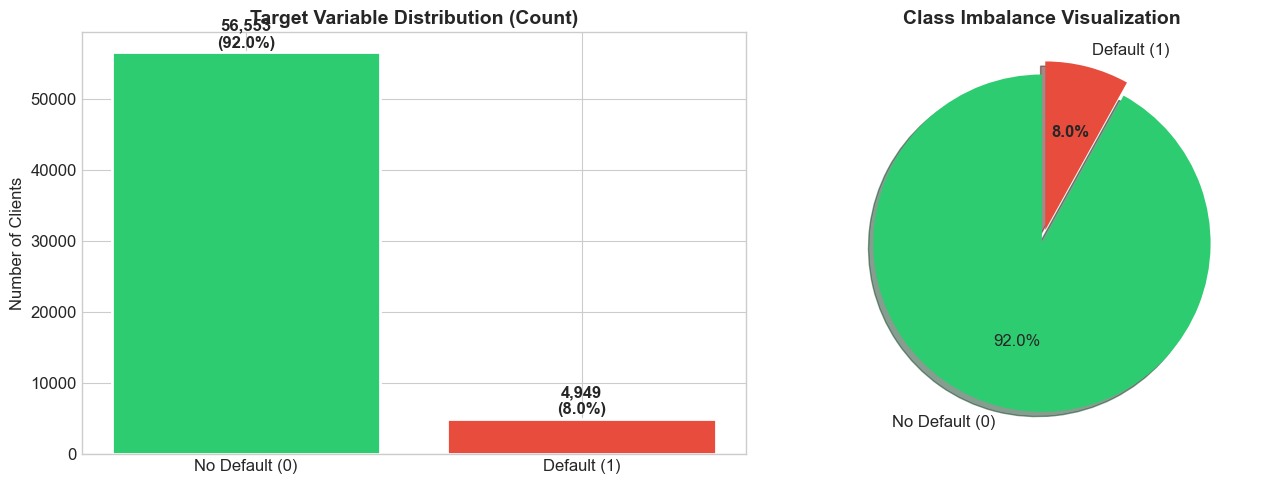


KEY FINDING: Severe class imbalance detected!
   SMOTE, class_weight, or stratified sampling should be used during modeling.


In [6]:
# Target variable distribution
target_counts = app_train['TARGET'].value_counts()
target_pct = app_train['TARGET'].value_counts(normalize=True) * 100

print("="*50)
print("TARGET VARIABLE DISTRIBUTION")
print("="*50)
print(f"\nNo default (TARGET=0): {target_counts[0]:,} ({target_pct[0]:.2f}%)")
print(f"Default    (TARGET=1): {target_counts[1]:,} ({target_pct[1]:.2f}%)")
print(f"\nImbalance ratio: 1:{target_counts[0]//target_counts[1]}")
print(f"Total records: {len(app_train):,}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['No Default (0)', 'Default (1)'], target_counts.values, color=colors, edgecolor='white', linewidth=2)
axes[0].set_title('Target Variable Distribution (Count)', fontweight='bold')
axes[0].set_ylabel('Number of Clients')
for bar, count, pct in zip(bars, target_counts.values, target_pct.values):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 200,
                f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Pie chart
wedges, texts, autotexts = axes[1].pie(
    target_counts.values, 
    labels=['No Default (0)', 'Default (1)'],
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0, 0.08),
    shadow=True,
    textprops={'fontsize': 12}
)
autotexts[1].set_fontweight('bold')
axes[1].set_title('Class Imbalance Visualization', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'notebooks', 'plots', 'target_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nKEY FINDING: Severe class imbalance detected!")
print("   SMOTE, class_weight, or stratified sampling should be used during modeling.")

<a id='5'></a>
## 5. Missing Value Analysis

Missing values in large datasets directly impact model performance.  
We analyze missing value rates across all tables.

In [7]:
# Collect missing value info from all tables
all_missing = []
for name, df in datasets.items():
    missing = get_missing_info(df, table_name=name)
    if len(missing) > 0:
        all_missing.append(missing)

missing_report = pd.concat(all_missing, ignore_index=True)

print("="*70)
print(f"MISSING VALUE REPORT - {len(missing_report)} columns with missing data")
print("="*70)

# Per-table summary
table_missing_summary = missing_report.groupby('Table').agg(
    Columns_With_Missing=('Column', 'count'),
    Avg_Missing_Pct=('Missing_Pct', 'mean'),
    Max_Missing_Pct=('Missing_Pct', 'max'),
    Most_Missing_Column=('Column', 'first')
).sort_values('Max_Missing_Pct', ascending=False)

display(table_missing_summary)

MISSING VALUE REPORT - 163 columns with missing data


,Columns_With_Missing,Avg_Missing_Pct,Max_Missing_Pct,Most_Missing_Column
Table,,,,
previous_application,15,43.90,99.67,RATE_INTEREST_PRIMARY
bureau,6,38.95,77.04,AMT_ANNUITY
application_train,66,45.00,69.81,COMMONAREA_MEDI
application_test,63,45.85,68.41,NONLIVINGAPARTMENTS_MEDI
credit_card_balance,9,16.53,19.37,AMT_PAYMENT_CURRENT
POS_CASH_balance,2,0.25,0.26,CNT_INSTALMENT_FUTURE
installments_payments,2,0.03,0.03,DAYS_ENTRY_PAYMENT


In [8]:
# Main table (application_train) missing value details
train_missing = get_missing_info(app_train, 'application_train')

print(f"\nApplication Train: {len(train_missing)} columns with missing values (out of {app_train.shape[1]} total)")
print(f"\nTop 20 columns by missing percentage:")
display(train_missing.head(20))


Application Train: 66 columns with missing values (out of 122 total)

Top 20 columns by missing percentage:


,Table,Column,Missing_Count,Missing_Pct,Dtype
0,application_train,COMMONAREA_MEDI,42935,69.81,float32
1,application_train,COMMONAREA_AVG,42935,69.81,float32
2,application_train,COMMONAREA_MODE,42935,69.81,float32
3,application_train,NONLIVINGAPARTMENTS_MEDI,42645,69.34,float32
4,application_train,NONLIVINGAPARTMENTS_MODE,42645,69.34,float32
5,application_train,NONLIVINGAPARTMENTS_AVG,42645,69.34,float32
6,application_train,FONDKAPREMONT_MODE,42008,68.30,object
7,application_train,LIVINGAPARTMENTS_MODE,42002,68.29,float32
8,application_train,LIVINGAPARTMENTS_MEDI,42002,68.29,float32
9,application_train,LIVINGAPARTMENTS_AVG,42002,68.29,float32


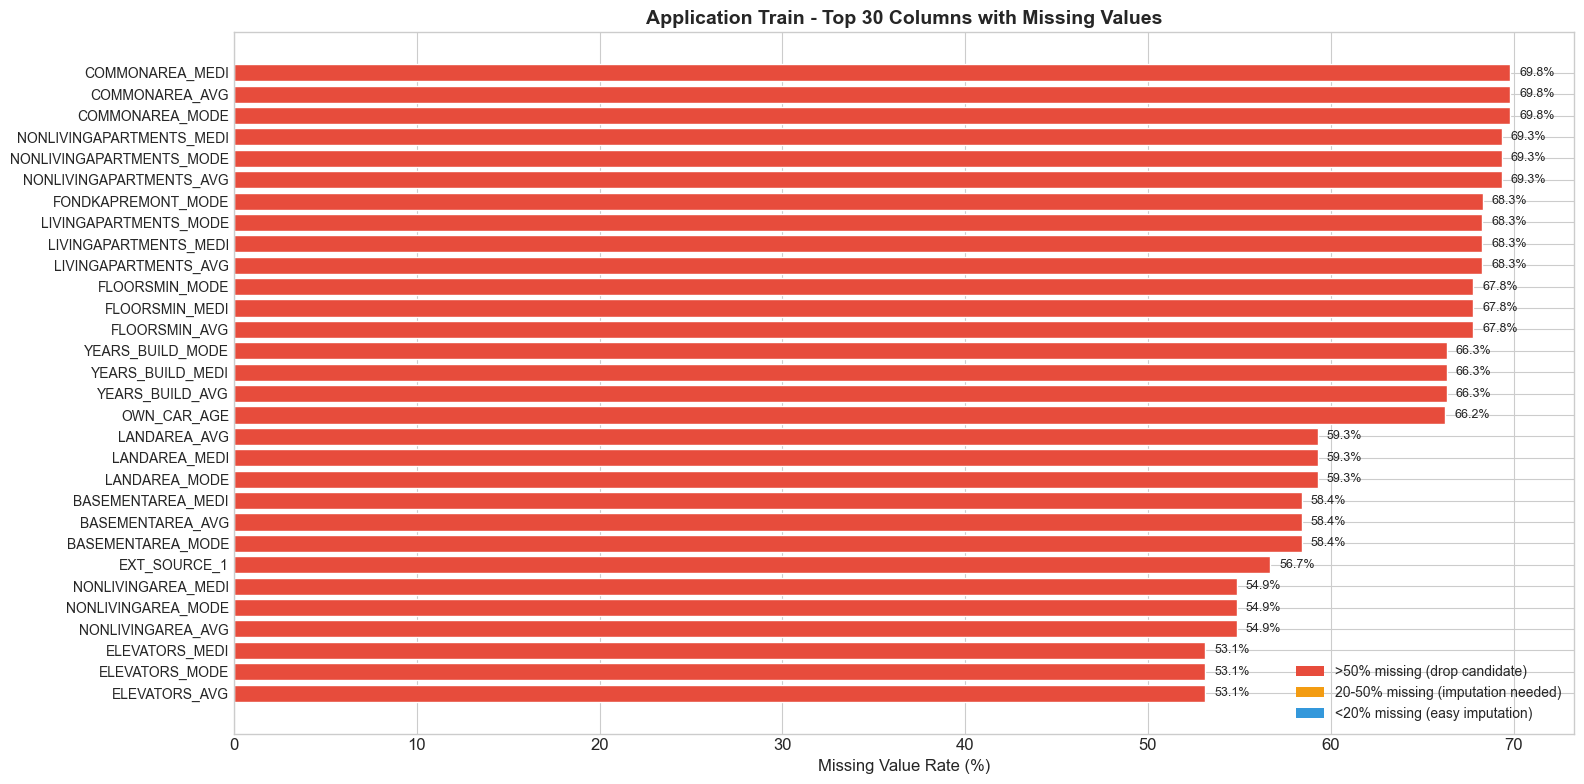

In [9]:
# Missing value bar chart - Top 30 columns from main table
top_missing_cols = train_missing.head(30)['Column'].tolist()

if len(top_missing_cols) > 0:
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Color-coded bar plot by severity
    missing_pcts = train_missing.head(30).set_index('Column')['Missing_Pct']
    colors_bar = ['#e74c3c' if x > 50 else '#f39c12' if x > 20 else '#3498db' for x in missing_pcts.values]
    
    bars = ax.barh(range(len(missing_pcts)), missing_pcts.values, color=colors_bar, edgecolor='white')
    ax.set_yticks(range(len(missing_pcts)))
    ax.set_yticklabels(missing_pcts.index, fontsize=10)
    ax.set_xlabel('Missing Value Rate (%)')
    ax.set_title('Application Train - Top 30 Columns with Missing Values', fontweight='bold')
    ax.invert_yaxis()
    
    # Annotate percentage values on bars
    for i, (bar, val) in enumerate(zip(bars, missing_pcts.values)):
        ax.text(val + 0.5, i, f'{val:.1f}%', va='center', fontsize=9)
    
    # Color legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#e74c3c', label='>50% missing (drop candidate)'),
        Patch(facecolor='#f39c12', label='20-50% missing (imputation needed)'),
        Patch(facecolor='#3498db', label='<20% missing (easy imputation)')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(PROJECT_ROOT, 'notebooks', 'plots', 'missing_values_train.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found!")

In [10]:
# Missing value strategy summary
high_missing = train_missing[train_missing['Missing_Pct'] > 50]
medium_missing = train_missing[(train_missing['Missing_Pct'] > 20) & (train_missing['Missing_Pct'] <= 50)]
low_missing = train_missing[train_missing['Missing_Pct'] <= 20]

print("\n" + "="*60)
print("MISSING VALUE STRATEGY SUMMARY")
print("="*60)
print(f"\n  >50% missing (drop candidates):       {len(high_missing)} columns")
print(f"  20-50% missing (imputation needed):    {len(medium_missing)} columns")
print(f"  <20% missing (easy imputation):        {len(low_missing)} columns")
print(f"  No missing values:                     {app_train.shape[1] - len(train_missing)} columns")


MISSING VALUE STRATEGY SUMMARY

  >50% missing (drop candidates):       41 columns
  20-50% missing (imputation needed):    9 columns
  <20% missing (easy imputation):        16 columns
  No missing values:                     56 columns


<a id='6'></a>
## 6. Numeric Feature Distributions

Examining the distributions of key financial indicators and their relationship with TARGET.

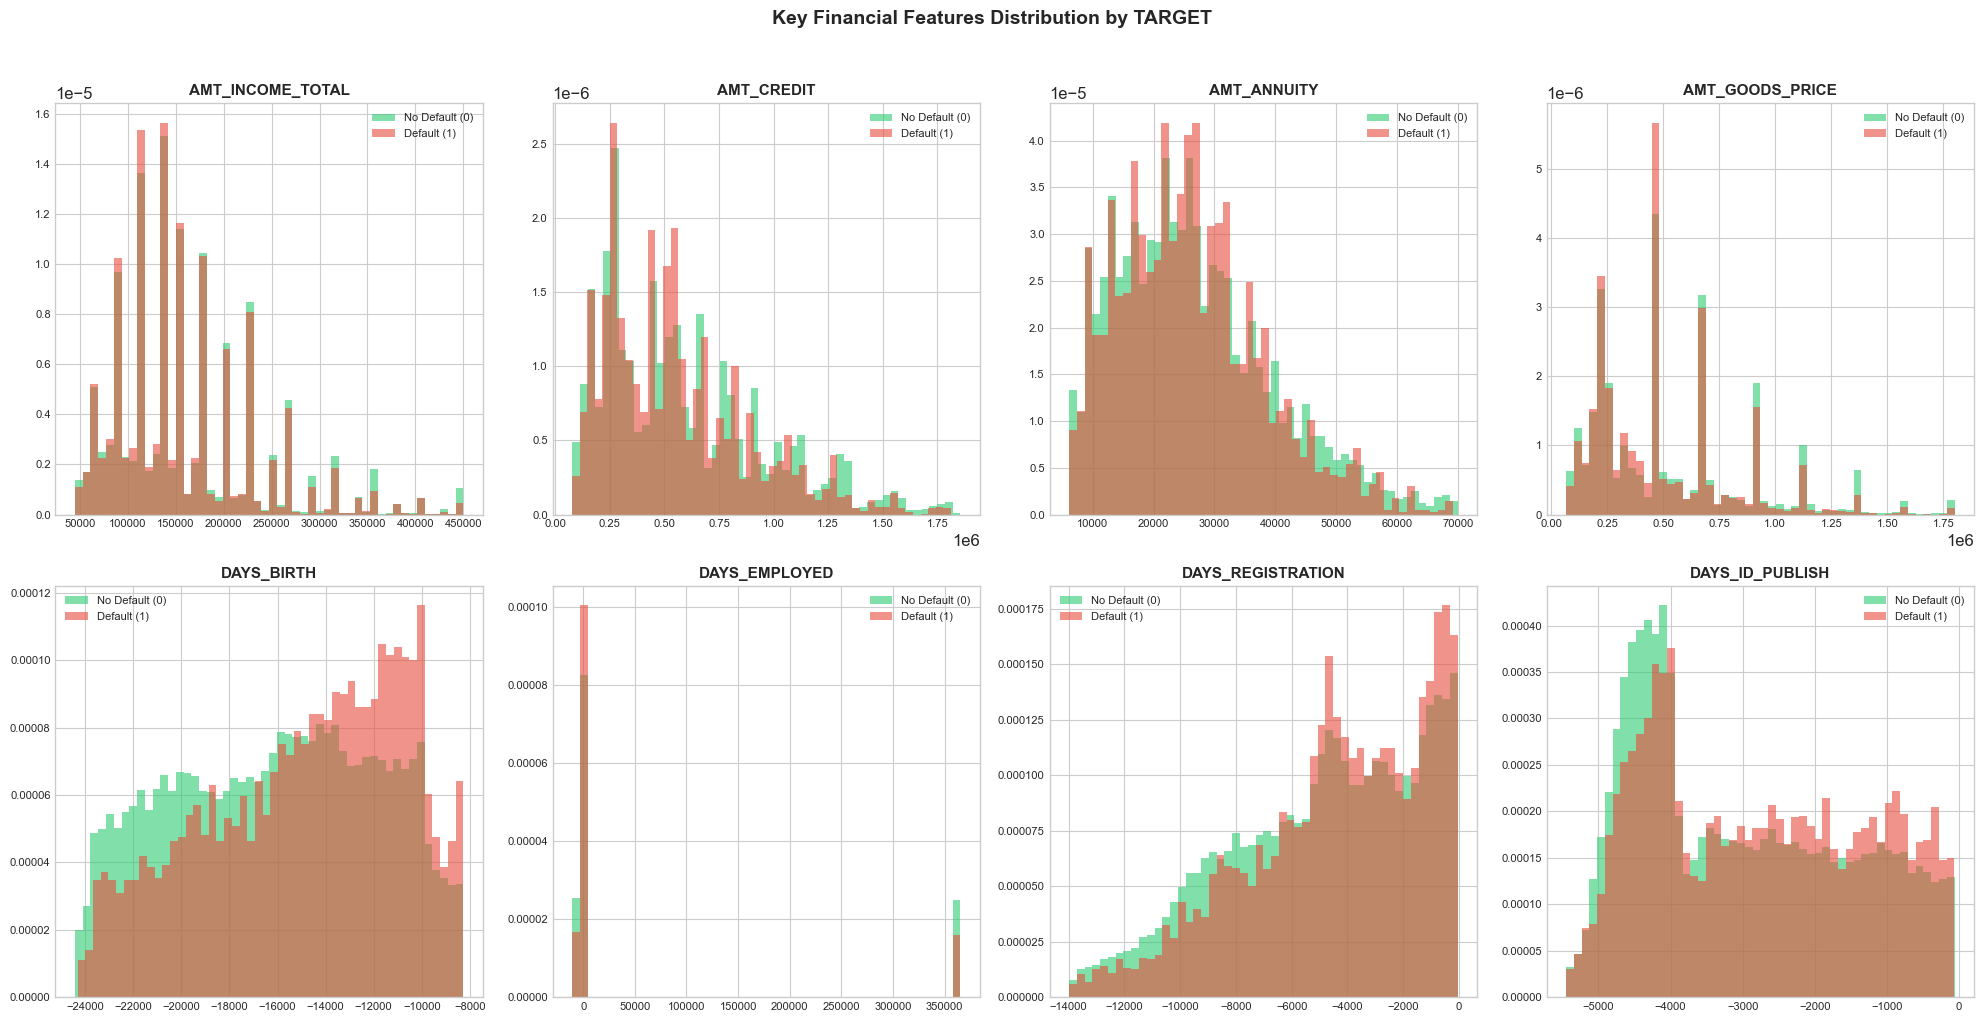

In [11]:
# Distribution of key financial features split by TARGET
key_numeric_cols = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'
]

# Keep only columns present in the dataset
key_numeric_cols = [col for col in key_numeric_cols if col in app_train.columns]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(key_numeric_cols):
    ax = axes[i]
    
    # Clip outliers at 1st and 99th percentiles for visualization
    data = app_train[col].dropna()
    q99 = data.quantile(0.99)
    q01 = data.quantile(0.01)
    
    # Split by TARGET=0 (no default) and TARGET=1 (default)
    mask_0 = (app_train['TARGET'] == 0) & (app_train[col] >= q01) & (app_train[col] <= q99)
    mask_1 = (app_train['TARGET'] == 1) & (app_train[col] >= q01) & (app_train[col] <= q99)
    
    ax.hist(app_train.loc[mask_0, col], bins=50, alpha=0.6, color='#2ecc71', label='No Default (0)', density=True)
    ax.hist(app_train.loc[mask_1, col], bins=50, alpha=0.6, color='#e74c3c', label='Default (1)', density=True)
    
    ax.set_title(col, fontweight='bold', fontsize=11)
    ax.legend(fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

plt.suptitle('Key Financial Features Distribution by TARGET', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'notebooks', 'plots', 'numeric_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

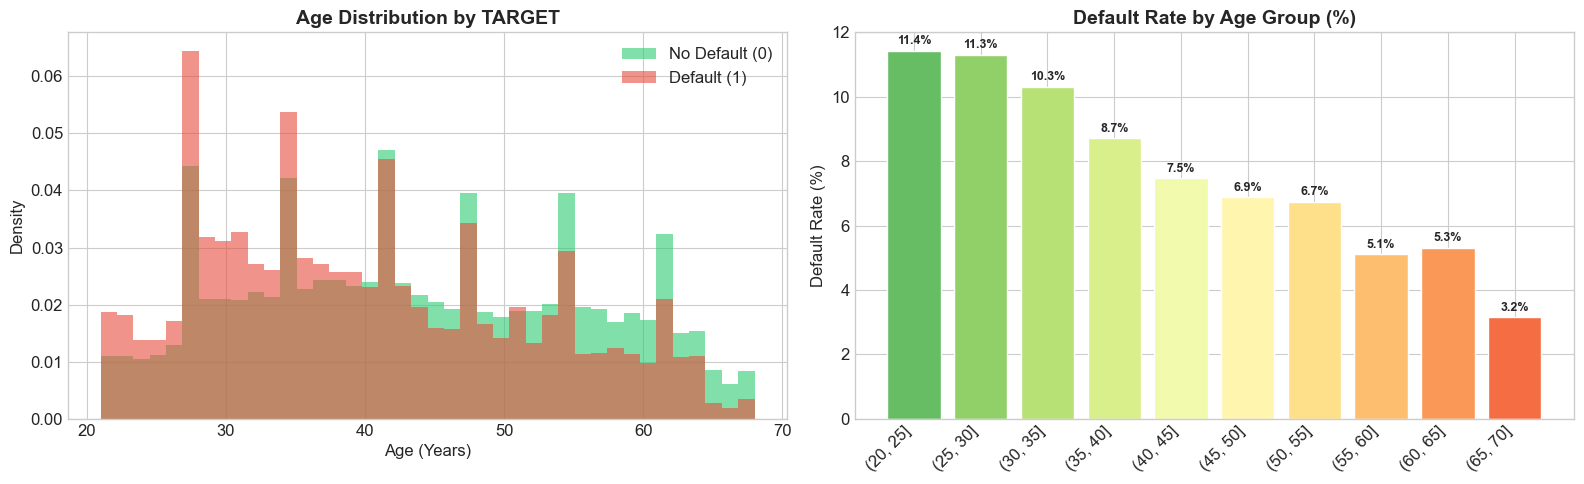


FINDING: Younger clients (20-30) have significantly higher default rates.
         Default rate decreases as age increases.


In [12]:
# Age analysis (DAYS_BIRTH is stored as negative days from application date)
app_train['AGE_YEARS'] = (-app_train['DAYS_BIRTH'] / 365.25).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Age distribution split by TARGET
for target_val, color, label in [(0, '#2ecc71', 'No Default'), (1, '#e74c3c', 'Default')]:
    subset = app_train[app_train['TARGET'] == target_val]['AGE_YEARS']
    axes[0].hist(subset, bins=40, alpha=0.6, color=color, label=f'{label} ({target_val})', density=True)

axes[0].set_title('Age Distribution by TARGET', fontweight='bold')
axes[0].set_xlabel('Age (Years)')
axes[0].set_ylabel('Density')
axes[0].legend()

# Default rate by age group
age_bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
app_train['AGE_GROUP'] = pd.cut(app_train['AGE_YEARS'], bins=age_bins)
age_target = app_train.groupby('AGE_GROUP', observed=False)['TARGET'].mean() * 100

bars = axes[1].bar(range(len(age_target)), age_target.values, 
                    color=plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(age_target))),
                    edgecolor='white')
axes[1].set_xticks(range(len(age_target)))
axes[1].set_xticklabels([str(x) for x in age_target.index], rotation=45, ha='right')
axes[1].set_title('Default Rate by Age Group (%)', fontweight='bold')
axes[1].set_ylabel('Default Rate (%)')

for bar, val in zip(bars, age_target.values):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
                f'{val:.1f}%', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'notebooks', 'plots', 'age_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nFINDING: Younger clients (20-30) have significantly higher default rates.")
print("         Default rate decreases as age increases.")

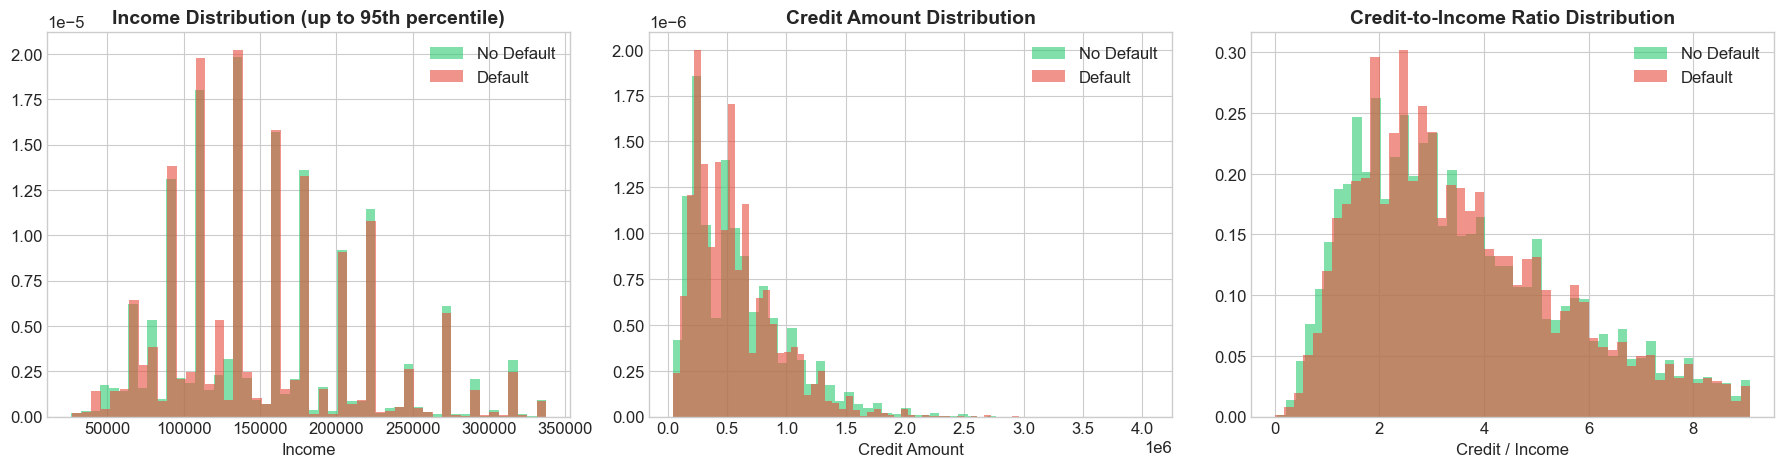

In [13]:
# Income and credit amount analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Income distribution (capped at 95th percentile to handle outliers)
income_cap = app_train['AMT_INCOME_TOTAL'].quantile(0.95)
for target_val, color, label in [(0, '#2ecc71', 'No Default'), (1, '#e74c3c', 'Default')]:
    subset = app_train[(app_train['TARGET'] == target_val) & (app_train['AMT_INCOME_TOTAL'] <= income_cap)]
    axes[0].hist(subset['AMT_INCOME_TOTAL'], bins=50, alpha=0.6, color=color, label=f'{label}', density=True)
axes[0].set_title('Income Distribution (up to 95th percentile)', fontweight='bold')
axes[0].set_xlabel('Income')
axes[0].legend()

# 2. Credit amount distribution
for target_val, color, label in [(0, '#2ecc71', 'No Default'), (1, '#e74c3c', 'Default')]:
    subset = app_train[app_train['TARGET'] == target_val]
    axes[1].hist(subset['AMT_CREDIT'], bins=50, alpha=0.6, color=color, label=f'{label}', density=True)
axes[1].set_title('Credit Amount Distribution', fontweight='bold')
axes[1].set_xlabel('Credit Amount')
axes[1].legend()

# 3. Credit-to-income ratio
app_train['CREDIT_INCOME_RATIO'] = app_train['AMT_CREDIT'] / (app_train['AMT_INCOME_TOTAL'] + 1)
ratio_cap = app_train['CREDIT_INCOME_RATIO'].quantile(0.95)
for target_val, color, label in [(0, '#2ecc71', 'No Default'), (1, '#e74c3c', 'Default')]:
    subset = app_train[(app_train['TARGET'] == target_val) & (app_train['CREDIT_INCOME_RATIO'] <= ratio_cap)]
    axes[2].hist(subset['CREDIT_INCOME_RATIO'], bins=50, alpha=0.6, color=color, label=f'{label}', density=True)
axes[2].set_title('Credit-to-Income Ratio Distribution', fontweight='bold')
axes[2].set_xlabel('Credit / Income')
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'notebooks', 'plots', 'income_credit_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

<a id='7'></a>
## 7. Categorical Feature Analysis

Examining the relationship between categorical features and default rates.

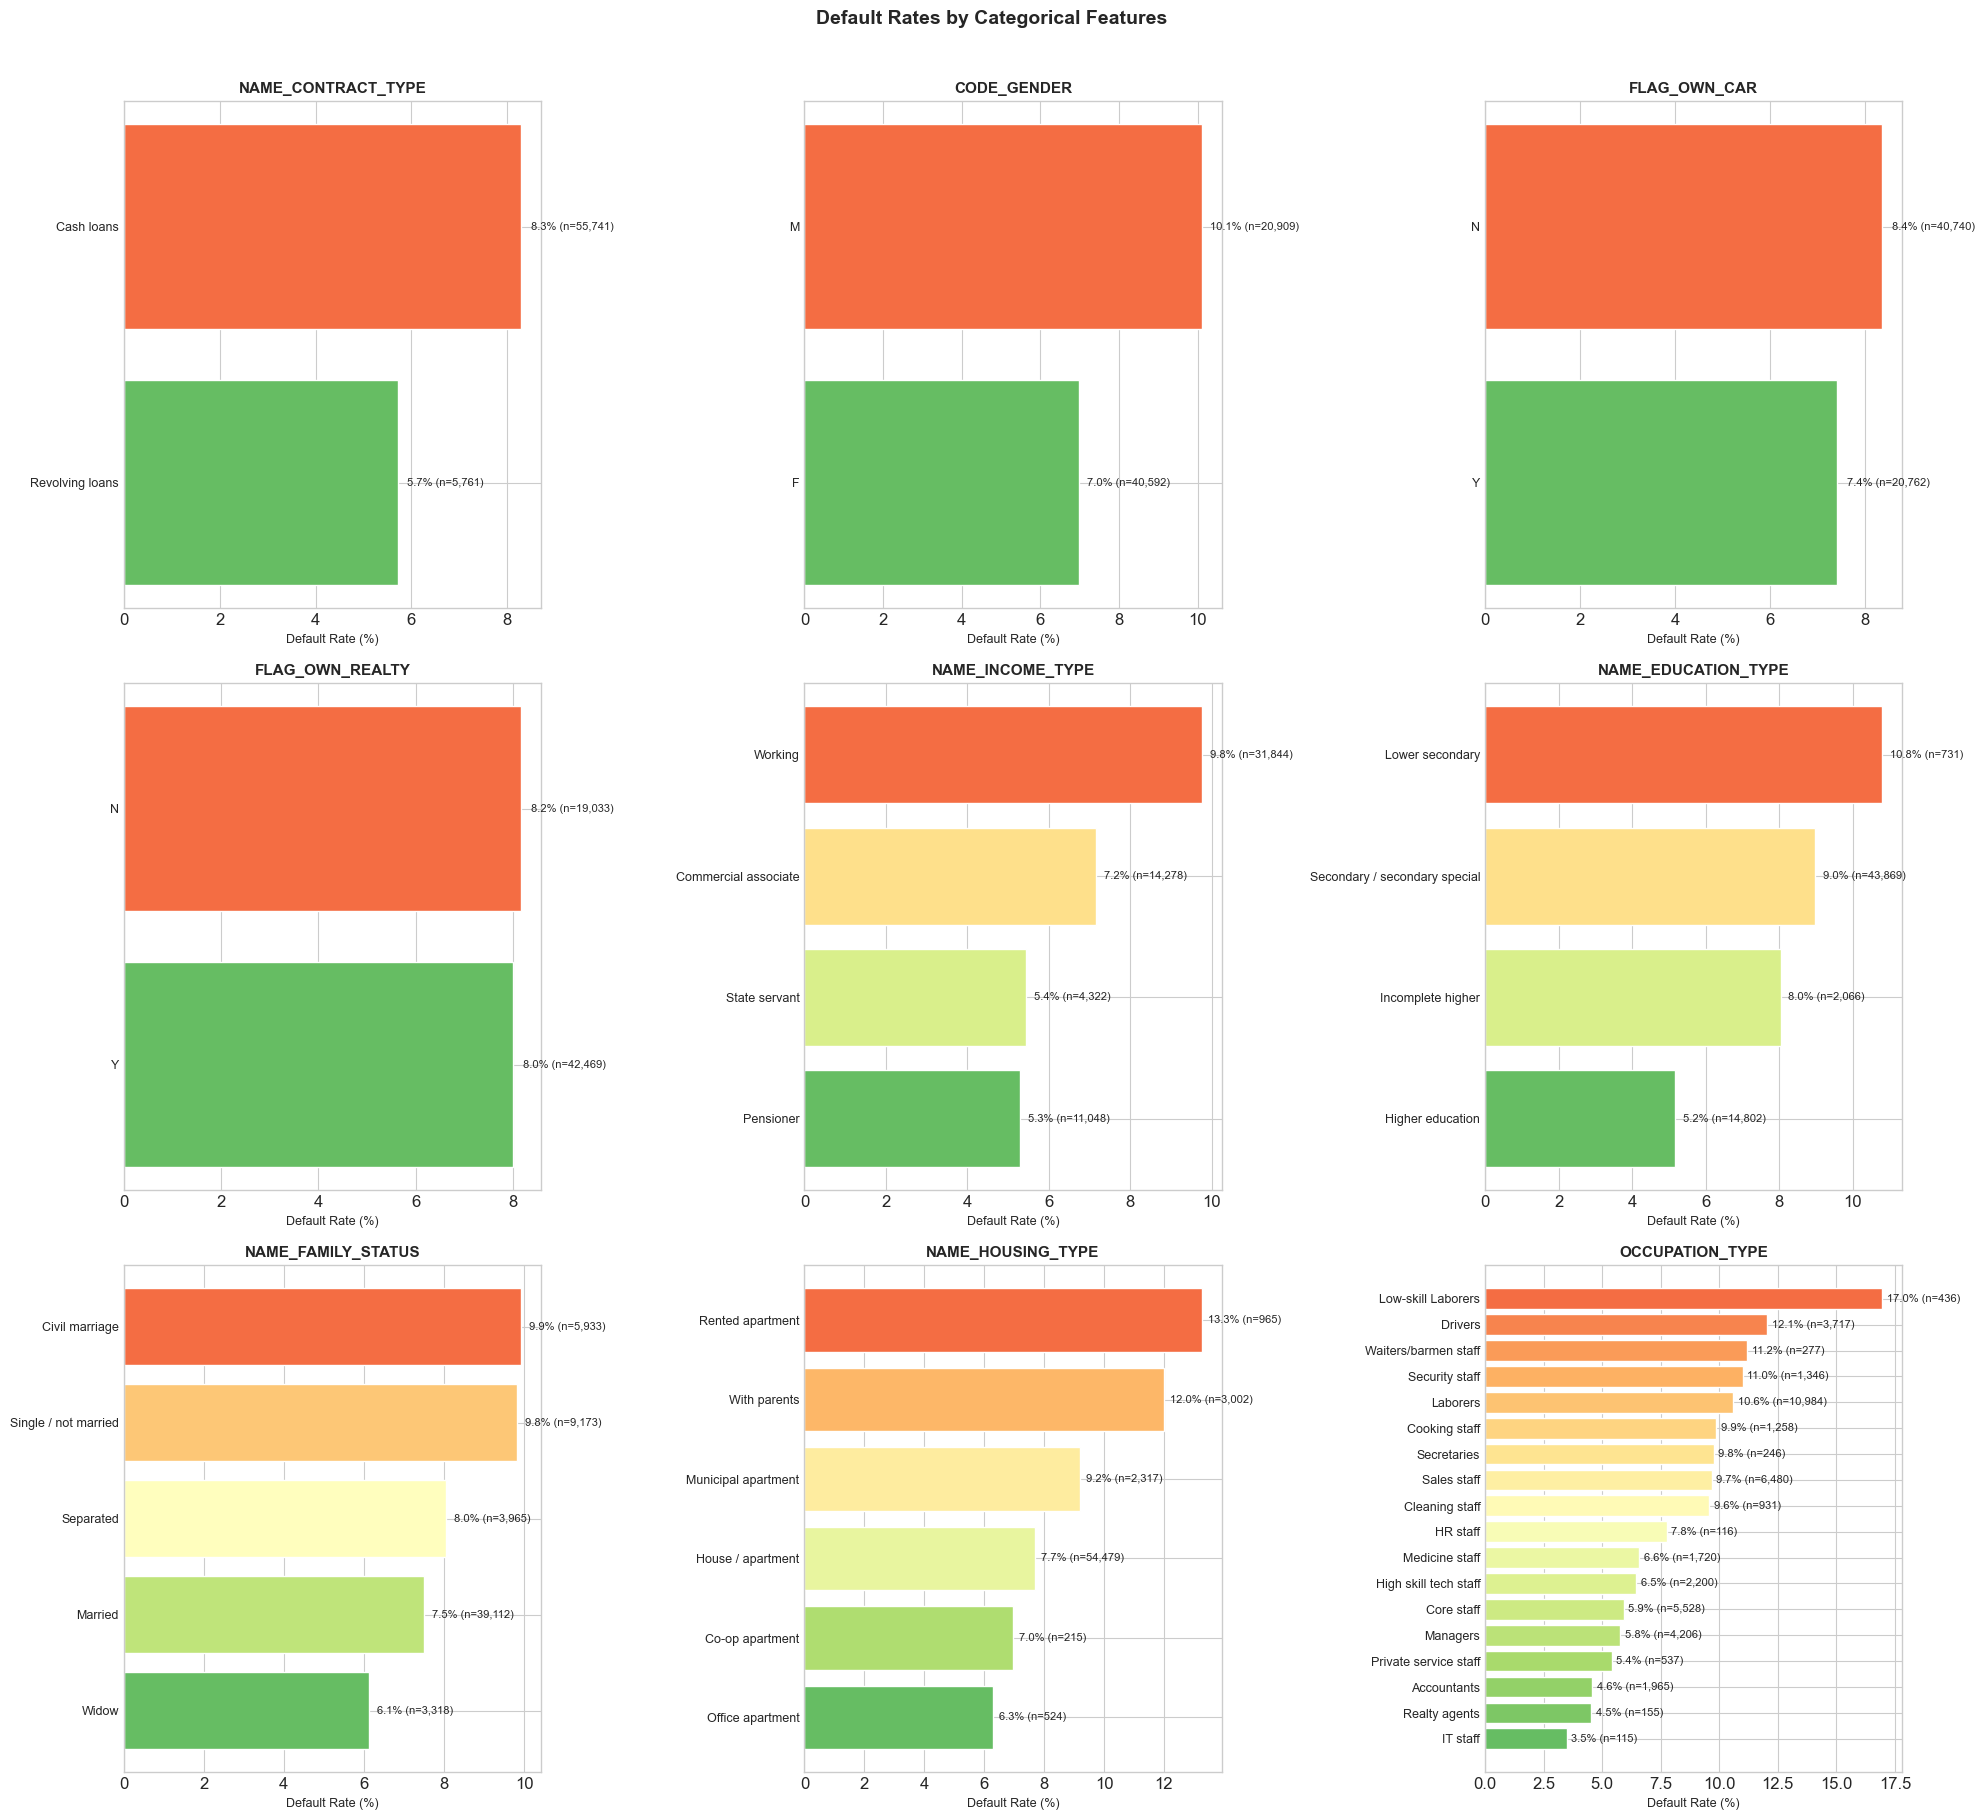

In [14]:
# Default rates by categorical features
cat_cols = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE'
]
cat_cols = [col for col in cat_cols if col in app_train.columns]

fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    # Compute default rate per category
    cat_target = app_train.groupby(col)['TARGET'].agg(['mean', 'count']).reset_index()
    cat_target.columns = [col, 'default_rate', 'count']
    cat_target['default_rate'] *= 100
    cat_target = cat_target.sort_values('default_rate', ascending=True)
    
    # Only show categories with at least 50 records
    cat_target = cat_target[cat_target['count'] >= 50]
    
    colors_cat = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(cat_target)))
    bars = ax.barh(range(len(cat_target)), cat_target['default_rate'].values, 
                    color=colors_cat, edgecolor='white')
    ax.set_yticks(range(len(cat_target)))
    ax.set_yticklabels(cat_target[col].values, fontsize=9)
    ax.set_title(f'{col}', fontweight='bold', fontsize=11)
    ax.set_xlabel('Default Rate (%)', fontsize=9)
    
    for bar, val, count in zip(bars, cat_target['default_rate'].values, cat_target['count'].values):
        ax.text(val + 0.2, bar.get_y() + bar.get_height()/2.,
                f'{val:.1f}% (n={count:,})', va='center', fontsize=8)

plt.suptitle('Default Rates by Categorical Features', fontweight='bold', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'notebooks', 'plots', 'categorical_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Highest-risk category for each categorical feature
print("="*70)
print("CATEGORICAL FEATURE SUMMARY - Highest Default Rate Categories")
print("="*70)

for col in cat_cols:
    cat_summary = app_train.groupby(col)['TARGET'].agg(['mean', 'count']).reset_index()
    cat_summary.columns = [col, 'default_rate', 'count']
    cat_summary['default_rate'] *= 100
    cat_summary = cat_summary[cat_summary['count'] >= 50]
    top = cat_summary.sort_values('default_rate', ascending=False).iloc[0]
    
    print(f"\n  {col}:")
    print(f"    Riskiest: {top[col]} -> Default: {top['default_rate']:.1f}% (n={int(top['count']):,})")

CATEGORICAL FEATURE SUMMARY - Highest Default Rate Categories

  NAME_CONTRACT_TYPE:
    Riskiest: Cash loans -> Default: 8.3% (n=55,741)

  CODE_GENDER:
    Riskiest: M -> Default: 10.1% (n=20,909)

  FLAG_OWN_CAR:
    Riskiest: N -> Default: 8.4% (n=40,740)

  FLAG_OWN_REALTY:
    Riskiest: N -> Default: 8.2% (n=19,033)

  NAME_INCOME_TYPE:
    Riskiest: Working -> Default: 9.8% (n=31,844)

  NAME_EDUCATION_TYPE:
    Riskiest: Lower secondary -> Default: 10.8% (n=731)

  NAME_FAMILY_STATUS:
    Riskiest: Civil marriage -> Default: 9.9% (n=5,933)

  NAME_HOUSING_TYPE:
    Riskiest: Rented apartment -> Default: 13.3% (n=965)

  OCCUPATION_TYPE:
    Riskiest: Low-skill Laborers -> Default: 17.0% (n=436)


<a id='8'></a>
## 8. Correlation Analysis

Identifying features with the strongest correlation to the TARGET variable.

In [16]:
# Pearson correlations with TARGET (numeric features only)
numeric_cols = app_train.select_dtypes(include=[np.number]).columns.tolist()
correlations = app_train[numeric_cols].corr()['TARGET'].drop('TARGET').sort_values(ascending=False)

# Top positive and negative correlations
top_positive = correlations.head(15)
top_negative = correlations.tail(15)
top_corr = pd.concat([top_positive, top_negative])

print("="*60)
print("STRONGEST CORRELATIONS WITH TARGET")
print("="*60)

print("\nTop POSITIVE correlations (increase default risk):")
for col, corr in top_positive.items():
    print(f"  {col:45s} -> r = {corr:+.4f}")

print("\nTop NEGATIVE correlations (decrease default risk):")
for col, corr in top_negative.items():
    print(f"  {col:45s} -> r = {corr:+.4f}")

STRONGEST CORRELATIONS WITH TARGET

Top POSITIVE correlations (increase default risk):
  DAYS_BIRTH                                    -> r = +0.0807
  REGION_RATING_CLIENT                          -> r = +0.0623
  REGION_RATING_CLIENT_W_CITY                   -> r = +0.0621
  DAYS_LAST_PHONE_CHANGE                        -> r = +0.0608
  REG_CITY_NOT_WORK_CITY                        -> r = +0.0509
  DAYS_ID_PUBLISH                               -> r = +0.0484
  FLAG_EMP_PHONE                                -> r = +0.0472
  REG_CITY_NOT_LIVE_CITY                        -> r = +0.0440
  FLAG_DOCUMENT_3                               -> r = +0.0435
  DAYS_REGISTRATION                             -> r = +0.0430
  OWN_CAR_AGE                                   -> r = +0.0406
  DEF_30_CNT_SOCIAL_CIRCLE                      -> r = +0.0308
  LIVE_CITY_NOT_WORK_CITY                       -> r = +0.0298
  DEF_60_CNT_SOCIAL_CIRCLE                      -> r = +0.0280
  FLAG_WORK_PHONE              

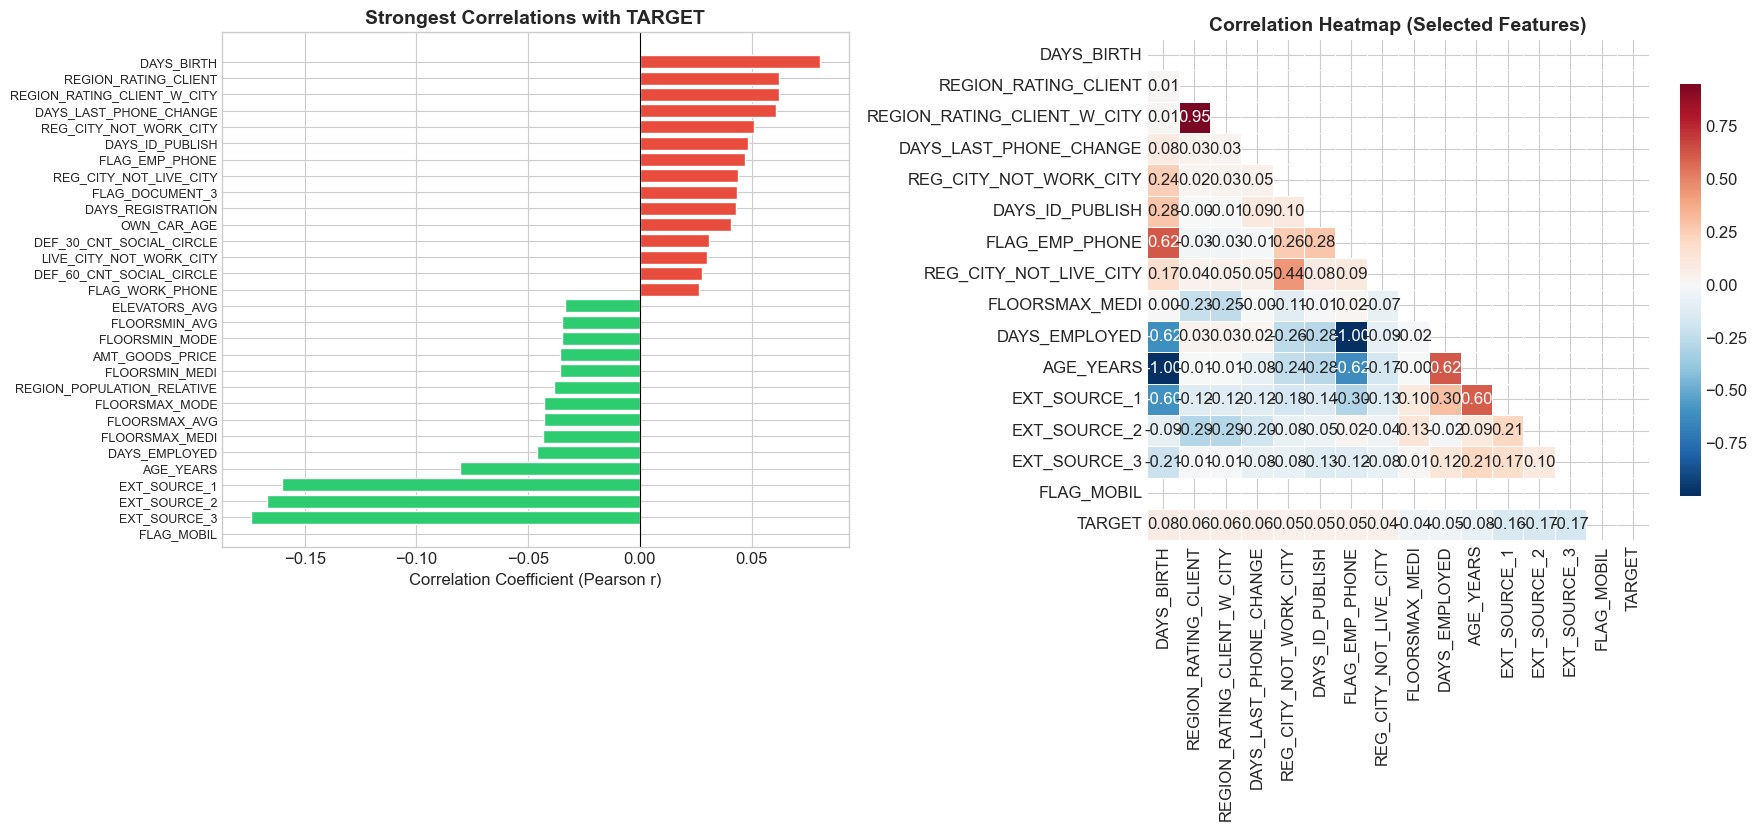

In [17]:
# Correlation visualizations
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left: Horizontal bar chart of strongest correlations with TARGET
colors_corr = ['#e74c3c' if x > 0 else '#2ecc71' for x in top_corr.values]
axes[0].barh(range(len(top_corr)), top_corr.values, color=colors_corr, edgecolor='white')
axes[0].set_yticks(range(len(top_corr)))
axes[0].set_yticklabels(top_corr.index, fontsize=9)
axes[0].set_xlabel('Correlation Coefficient (Pearson r)')
axes[0].set_title('Strongest Correlations with TARGET', fontweight='bold')
axes[0].axvline(x=0, color='black', linewidth=0.8)
axes[0].invert_yaxis()

# Right: Correlation heatmap for selected features
selected_cols = list(top_positive.head(8).index) + list(top_negative.tail(7).index) + ['TARGET']
selected_cols = [col for col in selected_cols if col in app_train.columns]

corr_matrix = app_train[selected_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, 
            annot=True, fmt='.2f', square=True, linewidths=0.5,
            ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title('Correlation Heatmap (Selected Features)', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'notebooks', 'plots', 'correlation_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

<a id='9'></a>
## 9. Auxiliary Tables Analysis

Deep-dive into the supplementary tables that are critical for dynamic risk scoring:  
`installments_payments`, `bureau`, `credit_card_balance`, and `previous_application`.

In [18]:
# Bureau table - External credit bureau records
if bureau is not None:
    print("="*60)
    print("BUREAU TABLE ANALYSIS")
    print("="*60)
    
    # Number of external credits per client
    bureau_count = bureau.groupby('SK_ID_CURR').size()
    print(f"\nAverage external credits per client: {bureau_count.mean():.1f}")
    print(f"Maximum external credits per client: {bureau_count.max()}")
    
    # Credit status distribution
    print(f"\nCredit Status (CREDIT_ACTIVE):")
    credit_active = bureau['CREDIT_ACTIVE'].value_counts()
    for status, count in credit_active.items():
        print(f"  {status}: {count:,} ({count/len(bureau)*100:.1f}%)")
    
    # Days overdue statistics
    overdue = bureau['CREDIT_DAY_OVERDUE']
    print(f"\nDays Overdue (CREDIT_DAY_OVERDUE):")
    print(f"  Non-zero: {(overdue > 0).sum():,} ({(overdue > 0).mean()*100:.2f}%)")
    print(f"  Mean (>0): {overdue[overdue > 0].mean():.0f} days")
    print(f"  Maximum:   {overdue.max():,} days")

BUREAU TABLE ANALYSIS

Average external credits per client: 5.5
Maximum external credits per client: 51

Credit Status (CREDIT_ACTIVE):
  Closed: 182,663 (62.6%)
  Active: 108,121 (37.0%)
  Sold: 1,159 (0.4%)
  Bad debt: 4 (0.0%)

Days Overdue (CREDIT_DAY_OVERDUE):
  Non-zero: 771 (0.26%)
  Mean (>0): 324 days
  Maximum:   2,703 days


INSTALLMENT PAYMENT HISTORY ANALYSIS

Total installment records: 2,313,225


Late payments (DPD > 0):     198,502 (8.6%)
Serious delay (DPD > 30):    7,108 (0.3%)
Critical delay (DPD > 90):   2,363 (0.10%)

Underpayments (shortfall > 0): 223,561 (9.7%)


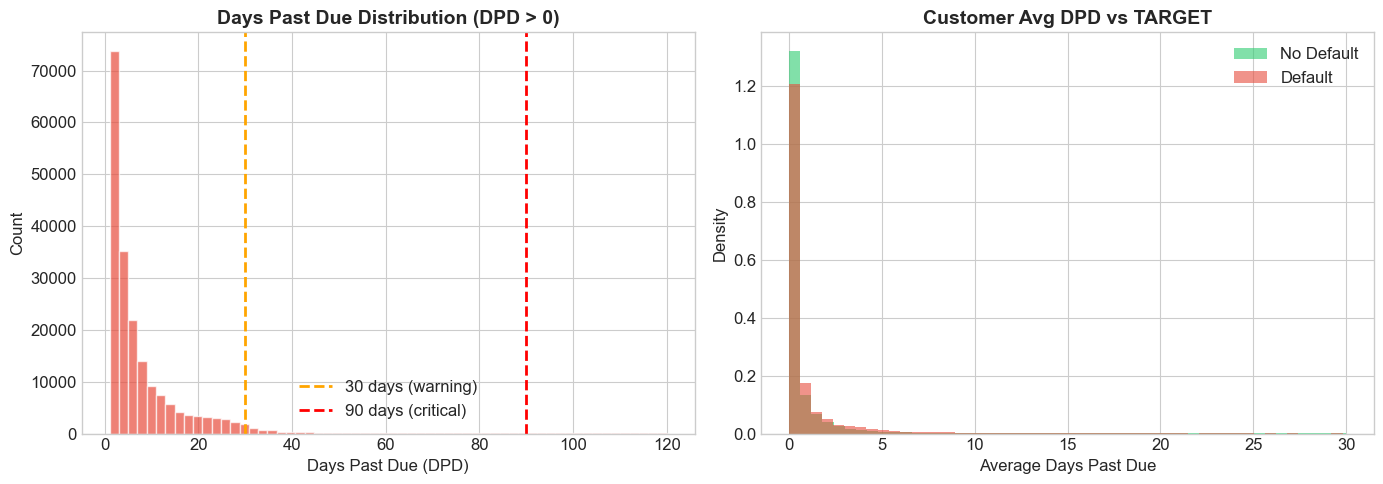


FINDING: Defaulting clients have significantly higher average DPD.
         DPD will be one of the strongest features in feature engineering.


In [19]:
# Installment payments - Payment history & DPD (Days Past Due) analysis
if inst_pay is not None:
    print("="*60)
    print("INSTALLMENT PAYMENT HISTORY ANALYSIS")
    print("="*60)
    
    # Calculate Days Past Due (DPD)
    # DAYS_INSTALMENT: scheduled payment date, DAYS_ENTRY_PAYMENT: actual payment date
    # Both are negative (relative to application date); positive diff = late payment
    inst_pay['DPD'] = inst_pay['DAYS_ENTRY_PAYMENT'] - inst_pay['DAYS_INSTALMENT']
    inst_pay['DPD'] = inst_pay['DPD'].clip(lower=0)  # Negative diff (early payment) -> 0
    
    # Payment shortfall (underpayment amount)
    inst_pay['PAYMENT_DIFF'] = inst_pay['AMT_INSTALMENT'] - inst_pay['AMT_PAYMENT']
    
    print(f"\nTotal installment records: {len(inst_pay):,}")
    print(f"Late payments (DPD > 0):     {(inst_pay['DPD'] > 0).sum():,} ({(inst_pay['DPD'] > 0).mean()*100:.1f}%)")
    print(f"Serious delay (DPD > 30):    {(inst_pay['DPD'] > 30).sum():,} ({(inst_pay['DPD'] > 30).mean()*100:.1f}%)")
    print(f"Critical delay (DPD > 90):   {(inst_pay['DPD'] > 90).sum():,} ({(inst_pay['DPD'] > 90).mean()*100:.2f}%)")
    print(f"\nUnderpayments (shortfall > 0): {(inst_pay['PAYMENT_DIFF'] > 0).sum():,} ({(inst_pay['PAYMENT_DIFF'] > 0).mean()*100:.1f}%)")
    
    # DPD distribution plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Distribution of late payment days
    dpd_positive = inst_pay[inst_pay['DPD'] > 0]['DPD']
    dpd_capped = dpd_positive[dpd_positive <= 120]  # Cap at 120 days for visualization
    axes[0].hist(dpd_capped, bins=60, color='#e74c3c', alpha=0.7, edgecolor='white')
    axes[0].axvline(x=30, color='orange', linestyle='--', linewidth=2, label='30 days (warning)')
    axes[0].axvline(x=90, color='red', linestyle='--', linewidth=2, label='90 days (critical)')
    axes[0].set_title('Days Past Due Distribution (DPD > 0)', fontweight='bold')
    axes[0].set_xlabel('Days Past Due (DPD)')
    axes[0].set_ylabel('Count')
    axes[0].legend()
    
    # Right: Customer-level average DPD vs TARGET
    customer_dpd = inst_pay.groupby('SK_ID_CURR')['DPD'].mean().reset_index()
    customer_dpd.columns = ['SK_ID_CURR', 'AVG_DPD']
    merged = app_train[['SK_ID_CURR', 'TARGET']].merge(customer_dpd, on='SK_ID_CURR', how='left')
    merged['AVG_DPD'] = merged['AVG_DPD'].fillna(0)
    
    for target_val, color, label in [(0, '#2ecc71', 'No Default'), (1, '#e74c3c', 'Default')]:
        subset = merged[(merged['TARGET'] == target_val) & (merged['AVG_DPD'] <= 30)]
        axes[1].hist(subset['AVG_DPD'], bins=50, alpha=0.6, color=color, label=label, density=True)
    
    axes[1].set_title('Customer Avg DPD vs TARGET', fontweight='bold')
    axes[1].set_xlabel('Average Days Past Due')
    axes[1].set_ylabel('Density')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(PROJECT_ROOT, 'notebooks', 'plots', 'dpd_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nFINDING: Defaulting clients have significantly higher average DPD.")
    print("         DPD will be one of the strongest features in feature engineering.")

CREDIT CARD BALANCE ANALYSIS

Total records: 640,453
Unique clients: 17,369


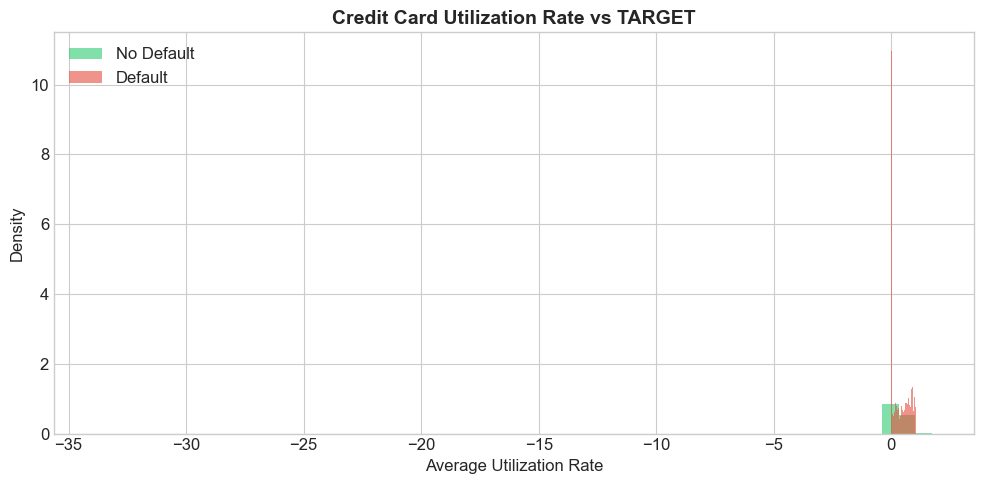

  Utilization Low (<30%): Default = 6.0% (n=10,063)
  Utilization Medium (30-70%): Default = 9.3% (n=4,276)
  Utilization High (>70%): Default = 15.4% (n=3,030)


In [20]:
# Credit card balance - Utilization rate analysis
if cc_bal is not None:
    print("="*60)
    print("CREDIT CARD BALANCE ANALYSIS")
    print("="*60)
    
    print(f"\nTotal records: {len(cc_bal):,}")
    print(f"Unique clients: {cc_bal['SK_ID_CURR'].nunique():,}")
    
    # Calculate credit utilization rate
    cc_bal['UTILIZATION_RATE'] = cc_bal['AMT_BALANCE'] / (cc_bal['AMT_CREDIT_LIMIT_ACTUAL'] + 1)
    
    # Customer-level average utilization
    cc_util = cc_bal.groupby('SK_ID_CURR')['UTILIZATION_RATE'].mean().reset_index()
    cc_util.columns = ['SK_ID_CURR', 'AVG_UTILIZATION']
    
    merged_cc = app_train[['SK_ID_CURR', 'TARGET']].merge(cc_util, on='SK_ID_CURR', how='inner')
    
    fig, ax = plt.subplots(figsize=(10, 5))
    for target_val, color, label in [(0, '#2ecc71', 'No Default'), (1, '#e74c3c', 'Default')]:
        subset = merged_cc[(merged_cc['TARGET'] == target_val) & (merged_cc['AVG_UTILIZATION'] <= 2)]
        ax.hist(subset['AVG_UTILIZATION'], bins=50, alpha=0.6, color=color, label=label, density=True)
    
    ax.set_title('Credit Card Utilization Rate vs TARGET', fontweight='bold')
    ax.set_xlabel('Average Utilization Rate')
    ax.set_ylabel('Density')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(PROJECT_ROOT, 'notebooks', 'plots', 'cc_utilization.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Compare default rates across utilization levels
    for label, threshold in [('Low (<30%)', 0.3), ('Medium (30-70%)', 0.7), ('High (>70%)', 999)]:
        if threshold == 0.3:
            mask = merged_cc['AVG_UTILIZATION'] < 0.3
        elif threshold == 0.7:
            mask = (merged_cc['AVG_UTILIZATION'] >= 0.3) & (merged_cc['AVG_UTILIZATION'] < 0.7)
        else:
            mask = merged_cc['AVG_UTILIZATION'] >= 0.7
        
        rate = merged_cc[mask]['TARGET'].mean() * 100
        count = mask.sum()
        print(f"  Utilization {label}: Default = {rate:.1f}% (n={count:,})")

PREVIOUS APPLICATION ANALYSIS

Total previous applications: 282,810
Unique clients: 58,231

Application Status:
  Approved: 177,249 (62.7%)
  Canceled: 51,789 (18.3%)
  Refused: 49,264 (17.4%)
  Unused offer: 4,508 (1.6%)


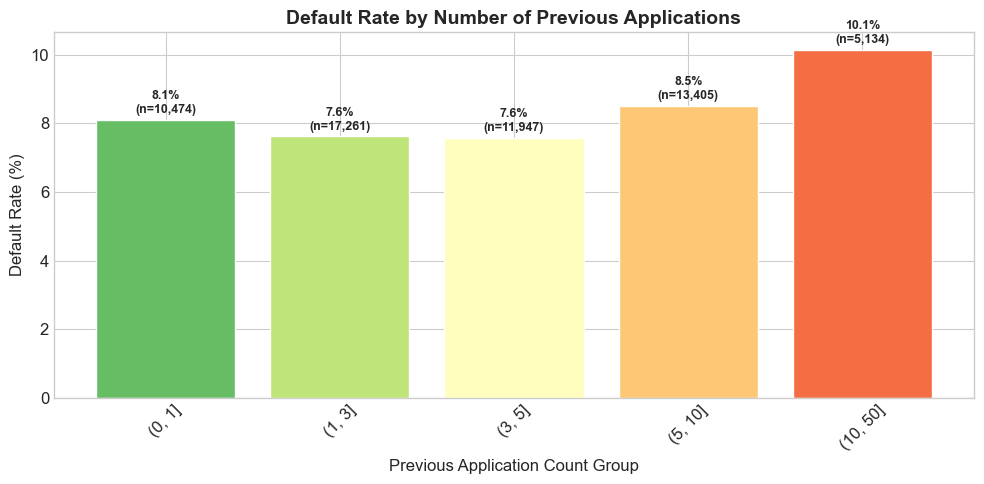

In [21]:
# Previous applications - Historical application behavior
if prev_app is not None:
    print("="*60)
    print("PREVIOUS APPLICATION ANALYSIS")
    print("="*60)
    
    print(f"\nTotal previous applications: {len(prev_app):,}")
    print(f"Unique clients: {prev_app['SK_ID_CURR'].nunique():,}")
    
    # Application status distribution
    if 'NAME_CONTRACT_STATUS' in prev_app.columns:
        status_dist = prev_app['NAME_CONTRACT_STATUS'].value_counts()
        print(f"\nApplication Status:")
        for status, count in status_dist.items():
            print(f"  {status}: {count:,} ({count/len(prev_app)*100:.1f}%)")
    
    # Number of previous applications per client vs default rate
    prev_count = prev_app.groupby('SK_ID_CURR').size().reset_index(name='PREV_APP_COUNT')
    merged_prev = app_train[['SK_ID_CURR', 'TARGET']].merge(prev_count, on='SK_ID_CURR', how='left')
    merged_prev['PREV_APP_COUNT'] = merged_prev['PREV_APP_COUNT'].fillna(0)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Group by application count ranges
    bins = [0, 1, 3, 5, 10, 50]
    merged_prev['PREV_GROUP'] = pd.cut(merged_prev['PREV_APP_COUNT'], bins=bins, right=True)
    group_target = merged_prev.groupby('PREV_GROUP', observed=False)['TARGET'].agg(['mean', 'count']).reset_index()
    group_target['mean'] *= 100
    
    bars = ax.bar(range(len(group_target)), group_target['mean'].values,
                  color=plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(group_target))),
                  edgecolor='white')
    ax.set_xticks(range(len(group_target)))
    ax.set_xticklabels([str(x) for x in group_target['PREV_GROUP']], rotation=45)
    ax.set_title('Default Rate by Number of Previous Applications', fontweight='bold')
    ax.set_ylabel('Default Rate (%)')
    ax.set_xlabel('Previous Application Count Group')
    
    for bar, val, cnt in zip(bars, group_target['mean'].values, group_target['count'].values):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.2,
                f'{val:.1f}%\n(n={cnt:,})', ha='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(PROJECT_ROOT, 'notebooks', 'plots', 'prev_app_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()

<a id='10'></a>
## 10. Summary & Next Steps

### Key EDA Findings

In [22]:
print("""
======================================================================
                       EDA SUMMARY FINDINGS
======================================================================

  1. CLASS IMBALANCE
     - TARGET=1 (default) rate is approximately 8%
     - Imbalance ratio ~1:11
     -> Solution: SMOTE, class_weight, stratified CV

  2. MISSING VALUES
     - Some columns have >50% missing (drop candidates)
     - EXT_SOURCE_1/2/3 (external scores) partially missing
     -> Solution: Threshold-based drop + median/mode imputation

  3. STRONGEST PREDICTORS
     - EXT_SOURCE variables (external credit scores) are the most
       powerful predictors of default
     - DAYS_BIRTH (age): Younger clients are riskier
     - DAYS_EMPLOYED: Longer employment reduces risk
     - AMT_CREDIT / AMT_INCOME_TOTAL ratio is significant

  4. CATEGORICAL FEATURES
     - Income type, education level, and occupation create
       significant risk differentiation
     - Cash loans vs Revolving loans show different risk profiles

  5. AUXILIARY TABLES (critical for Feature Engineering)
     - installments_payments: DPD (days past due) is a very
       strong default signal
     - credit_card_balance: Utilization rate is meaningful
     - bureau: External credit count and overdue history matter
     - previous_application: Past app count/status is important

======================================================================

  NEXT STEPS:
  1. Feature Engineering
     - Aggregate features from auxiliary tables
     - DPD, utilization, payment discipline metrics
  2. Data Preprocessing
     - Apply missing value strategy
     - Categorical encoding (Label / Target encoding)
  3. Model Training
     - LightGBM + XGBoost baseline models
     - Stratified K-Fold cross-validation
  4. Model Evaluation
     - AUC-ROC, Precision-Recall, SHAP explainability

======================================================================
""")


                       EDA SUMMARY FINDINGS

  1. CLASS IMBALANCE
     - TARGET=1 (default) rate is approximately 8%
     - Imbalance ratio ~1:11
     -> Solution: SMOTE, class_weight, stratified CV

  2. MISSING VALUES
     - Some columns have >50% missing (drop candidates)
     - EXT_SOURCE_1/2/3 (external scores) partially missing
     -> Solution: Threshold-based drop + median/mode imputation

  3. STRONGEST PREDICTORS
     - EXT_SOURCE variables (external credit scores) are the most
       powerful predictors of default
     - DAYS_BIRTH (age): Younger clients are riskier
     - DAYS_EMPLOYED: Longer employment reduces risk
     - AMT_CREDIT / AMT_INCOME_TOTAL ratio is significant

  4. CATEGORICAL FEATURES
     - Income type, education level, and occupation create
       significant risk differentiation
     - Cash loans vs Revolving loans show different risk profiles

  5. AUXILIARY TABLES (critical for Feature Engineering)
     - installments_payments: DPD (days past due) is a

In [23]:
# Clean up temporary variables to free memory
import gc

temp_vars = ['merged', 'merged_cc', 'merged_prev', 'customer_dpd', 'cc_util', 'prev_count']
for var in temp_vars:
    if var in dir():
        exec(f'del {var}')

gc.collect()
print("Memory cleaned up. EDA complete!")
print(f"\nLoaded tables: {list(datasets.keys())}")

Memory cleaned up. EDA complete!

Loaded tables: ['application_train', 'application_test', 'bureau', 'bureau_balance', 'previous_application', 'installments_payments', 'credit_card_balance', 'POS_CASH_balance']
